In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import urllib.request
import gzip
from collections import defaultdict, Counter
import pandas as pd
import csv
import requests
import itertools
import numpy as np
import json
import random as rd
import math
import pickle as pk

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

### Network generation and edge-filtering techniques


In this notebook, we will be on exploring different techniques for edge filtering and community detection in networks, as well as introducing additional layout options for visualizing networks effectively.

We will walk through three popular approaches for edge filtering in networks. By applying these techniques, we can highlight or remove specific edges based on various criteria, leading to a refined and focused network representation.


### Human Protein Atlas data

The Human Protein Atlas is a comprehensive resouce mapping proteins in cells, tissues, and organs through the whole range of -omics data.

Today we will use the "Tissue" section which provides the protein expression profiles in 44 different human tissues based on immunohistochemistry data.

The tab separated file includes several columns:
1. **Gene** -- the Ensembl gene identifier
2. **Tissue** -- the name of the tissue
3. **Cell type** -- the annotated cell type.
4. **Level** -- the expression level
5. **Reliability** -- the confidence of value in the "Level" column.

The data is based on The Human Protein Atlas version 22.0 and Ensembl version 103.38.

(source file 'normal_tissue.tsv' can be downloaded here: `www.proteinatlas.org/about/download`)

In [2]:
# Define the URL path where the file is located
path = 'https://www.proteinatlas.org/download/'

# Download and convert the data file into a DataFrame
data = pd.read_csv(path + 'normal_tissue.tsv.zip', sep='\t', compression='zip')
# Extract the 'Gene name' column values as gene symbols
gene_symbols = data['Gene name'].values

# Print the number of rows in the gene_symbols array
print('#total rows:', len(gene_symbols))

# Filter out rows where 'Reliability' is 'Uncertain'
data = data[data['Reliability'] != 'Uncertain']
# Define the values to exclude from the 'Level' column
exclude_values = [float('nan'), 'Not representative', 'Not detected']
# Filter out rows with excluded values in the 'Level' column
data = data[~data['Level'].isin(exclude_values)]


# Update variables with filtered column values
gene_symbols = data['Gene name'].values
tissue = data['Tissue'].values
celltype = data['Cell type'].values
explevel = data['Level'].values
reliab = data['Reliability'].values

# Print the number of rows after filtering and the count of unique tissues and cell types
print('# rows after filtering:', len(gene_symbols))
print('There are %s different tissues and %s different cell types remaining after filtering.' %
      (len(set(tissue)), len(set(celltype))))

# Create a dictionary to connect gene names with cell types
gene_celltype_dict = data.groupby('Gene name')['Cell type'].apply(list).to_dict()
# Create a dictionary where each gene name is associated with a set of unique cell types
gene_celltypeunique_dict = {k: set(v) for k, v in gene_celltype_dict.items()}

# Create a dictionary to connect cell types with genes
celltype_genes_dict = defaultdict(list)
for gene, celltypes in gene_celltypeunique_dict.items():
    for ct in celltypes:
        celltype_genes_dict[ct].append(gene)

# Create a dictionary where each cell type is associated with a set of unique genes
celltype_genesunique_dict = {k: set(v) for k, v in celltype_genes_dict.items()}
# Create a dictionary to connect cell types with tissues
celltype_tissue_dict = data.groupby('Cell type')['Tissue'].apply(list).to_dict()
# Create a dictionary where each cell type is associated with a set of unique tissues
celltype_tissueunique_dict = {k: set(v) for k, v in celltype_tissue_dict.items()}


# rows:  1194479
# rows after filtering:  516276
There are 63 different tissues and 143 different cell types remaining after filtering.


### Functions for preprocessing 

In [3]:
def jaccard_index(set1, set2):
    """
    Calculates the Jaccard index between two sets.
    The Jaccard index measures the similarity between two sets of genes
    by dividing the size of their intersection by the size of their union.

    Returns:
        float: The Jaccard index value, which represents the similarity between the two sets.
    """

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_index = intersection / union if union != 0 else 0
    return jaccard_index


def remove_low_ranked_edges(network, ranking_dict):
    """
    Filter procedure 
    Filters edges of a given network based on a dictionary 
    (ranking_dict) which contains edges with a score/weight
    The edge-removal stops at the breaking point of the network 
    -> number of components > 1. 

    Returns:
        nx.Graph: new network with a minimal set of edges
    """

    # Sort edges based on the ranking score in ascending order
    sorted_edges = sorted(ranking_dict.items(), key=lambda x: x[1])

    # Create a copy of the original network
    updated_network = network.copy()

    # Iterate through the sorted edges and remove low-ranked edges until the network becomes disconnected
    for edge, _ in sorted_edges:
        updated_network.remove_edge(*edge)  # Remove the edge from the network

        # Check if the network becomes disconnected
        if not nx.is_connected(updated_network):
            updated_network.add_edge(*edge)  # Add the edge back
        else:
            network = updated_network.copy()  # Update the network

    return updated_network


def make_json(name, network, positions, node_color = '#40b9d4', link_color = '#999999', annotations = 'None', communities = 'None'): 
    """
    Generates a JSON file from a given network graph using the specified parameters.

    Args:
        name (str, optional): Name of the graph.
        network (networkx.Graph): Network graph object.
        positions (dict): Dictionary mapping node IDs to their positions.
        node_color (dict): Dictionary mapping node IDs to their (hex-)colors.
        link_color (str or dict): (Hex-)color value for all links in the graph or dict with node tuple as key and hex color as value.
        communities (dict): 'None' for no communities (default) or dictionary mapping node IDs to their corresponding community ID.  
        annotations (dict): Dictionary mapping node IDs to a list of annotations.

    Returns:
        None

    """

    # --------------------------
    # Generate VR GRAPH 
    # --------------------------
    GVR = nx.Graph()
    GVR.graph['name'] = name

    # --------------------------------------
    # LOOKUP FOR NODE NAMES INTO IDs and vv
    # --------------------------------------
    d_idx_node = {}
    d_node_idx = {}
    for i, node in enumerate(sorted(network.nodes())):
        d_idx_node[i] = node
        d_node_idx[node] = i
    GVR.add_nodes_from(d_idx_node.keys())

    for edge in network.edges()(data=True):
        GVR.add_edge(d_node_idx[edge[0]],d_node_idx[edge[1]])

    # --------------------------
    # POS 
    # --------------------------
    if isinstance(positions[next(iter(positions))], list):
        pass
    else:
        for key in positions:
            positions[key] = positions[key].tolist()

    posG = {d_node_idx[node]: list(xyz) for node, xyz in positions.items()}
    nx.set_node_attributes(GVR, posG, name="pos")

    # # --------------------------
    # # CLUSTER 
    # # --------------------------
    if communities == 'None':
        d_VRids_cluster = dict(zip(d_idx_node.keys(), [0 for _ in d_idx_node.keys()]))
    else:
        d_VRids_cluster = {d_node_idx[node]: str(cl_id) for node, cl_id in communities.items()}        
    nx.set_node_attributes(GVR, d_VRids_cluster, name="cluster")


    # --------------------------
    # NODE COLOR
    # --------------------------
    d_node_colors={}

    if isinstance(node_color, dict):
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color[d_idx_node[nodeid]] 
    else:
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color

    nx.set_node_attributes(GVR, d_node_colors, name="nodecolor")

    # --------------------------
    # LINK COLOR
    # --------------------------
    if isinstance(link_color, dict):
        # for different link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            try:
                color = link_color[(d_idx_node[a],d_idx_node[b])]
            except KeyError: 
                color = link_color[(d_idx_node[b],d_idx_node[a])]
            d_edge_color[(a,b)] = color
    else:
        # for unique link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            d_edge_color[(a,b)] = link_color

    nx.set_edge_attributes(GVR, d_edge_color, name="linkcolor")

    # --------------------------
    # NODE ANNOTATION
    # --------------------------
    if isinstance(annotations, dict):

        l_annotations = [[str(d_idx_node[nodeid])] + [ annotation for annotation in annotations[d_idx_node[nodeid]]] for nodeid in sorted(GVR.nodes())]
        d_annotations = dict(zip(sorted(GVR.nodes()), l_annotations))
    else:
        d_annotations = {nodeid: [str(d_idx_node[nodeid])] for nodeid in GVR.nodes()}

    nx.set_node_attributes(GVR, d_annotations, name="annotation")

    # --------------------------
    # MAKE JSON fo uploader
    # --------------------------

    G_json = json.dumps(nx.node_link_data(GVR))

    with open(GVR.name+".json", "w") as outfile:
        outfile.write(G_json)



def plotly_preview(G, pos, node_colors=None, edge_colors=None):

    """
    Generate a 3D network visualization using Plotly.

    Parameters:
        - G (networkx.Graph): The graph object representing the network.
        - pos3D (dict): A dictionary mapping each node to its 3D coordinates (x, y, z).
        - node_colors (dict, optional): A dictionary mapping nodes to custom hex colors.
                                        If not provided, the default color is '#40b9d4'.
        - edge_colors (dict, optional): A dictionary mapping edges to custom hex colors.
                                        If not provided, the default color is 'gray'.

    Output:
        - An HTML file named 'network_visualization.html' is generated, which opens in a web browser.

    Example usage:
        node_colors = {1: '#ff0000', 2: '#00ff00', 3: '#0000ff'}
        edge_colors = {(1, 2): '#ff00ff', (2, 3): '#ffff00'}
        pos = nx.spring_layout(G,dim=3)
        plotly_review_2(G, pos, node_colors, edge_colors)
    """

    # Create a Plotly figure
    fig = go.Figure()

    # Add nodes to the figure
    for node in G.nodes():
        x, y, z = pos[node]
        color = node_colors[node] if node_colors and node in node_colors else '#40b9d4'
        fig.add_trace(go.Scatter3d(
            x=[x],
            y=[y],
            z=[z],
            mode='markers',
            marker=dict(
                size=5,
                color=color,
            ),
            name=str(node),
            text=str(node),
            hovertemplate=None,
        ))

    # Add edges to the figure
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_color = edge_colors[edge] if edge_colors and edge in edge_colors else 'gray'
        fig.add_trace(go.Scatter3d(
            x=[x0, x1],
            y=[y0, y1],
            z=[z0, z1],
            mode='lines',
            line=dict(
                color=edge_color,
                width=1,
            ),
            hoverinfo='none',
        ))

    # Set layout options
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(l=0, r=0, b=0, t=0),
    )

    # # Save the figure as an HTML file
    # fig.write_html('network_preview.html', auto_open=True)

    # Display the plot inline in the notebook
    iplot(fig)

### Cell type expression similarity network

Let's build a network where the **nodes** are cell types (ex. neuronal cells, endothelian cells, macrophages, ...) and **links** represent the similarity of genes expressed between two cell types.

We use the Jaccard index to assign a number to the similarity between two sets of genes.  The Jaccard index will range from [0,1], where 0 means that there aren't any shared genes, and 1 means all the genes are shared.

Later, we can choose a cut-off value to filter edges.  While we can choose a cut off arbitrarily, another way could be by inspecting the distribution of Jaccard indices.

At this point, we will just generate the network using all available edges, each with its respective similarity value (no cutoff).

In [4]:
pairwise_celltype_combinations = list(itertools.combinations(celltype_genesunique_dict.keys(), 2))
sim_cutoff = 0.0

G_celltype = nx.Graph()
l_sim_scores = []
for t1, t2 in pairwise_celltype_combinations:
    sim_score = jaccard_index(celltype_genesunique_dict[t1],celltype_genesunique_dict[t2])
    l_sim_scores.append(sim_score)
    if sim_score > sim_cutoff:
        G_celltype.add_edge(t1,t2,weight = sim_score)

print('# nodes: ', G_celltype.number_of_nodes())
print('# edges: ', G_celltype.number_of_edges())
print('# of connected components: ', nx.number_connected_components(G_celltype))
print('network density (# present links divided by all possible links): ', nx.density(G_celltype))


# OPTIONAL:
# consider the distribution of jaccard indices 
# plt.figure(figsize=(5,4))
# plt.hist(l_sim_scores, bins='auto', alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Jaccard index')
# plt.ylabel('Frequency')

# nodes:  143
# edges:  7948
# of connected components:  1
network density (# present links divided by all possible links):  0.782822810991825


### Filtering edges

#### Edge weights

The most obvious approach is to directly consider the weights on the network edges in order to find a criterion that allows us to determine a minimum value for the weights. Below this minimum, all edges would be neglected.

Text(0.32, 2000.0, 'Cutoff value at 0.3')

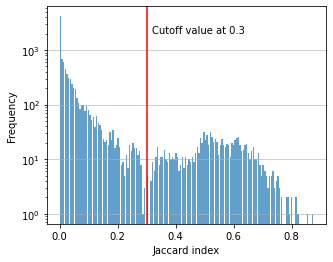

In [14]:

# consider the distribution of jaccard indices 
plt.figure(figsize=(5,4))
plt.hist(l_sim_scores, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Jaccard index')
plt.ylabel('Frequency')
plt.yscale('log')

plt.axvline(x=0.3, color='red')
plt.text(0.32, 2e3, 'Cutoff value at 0.3', color='k')

In [15]:
min_weight = 0.3
G_filteredweights = nx.Graph()

# Iterate over the edges and add edges with weights above the threshold to the filtered graph
for u, v, weight in G_celltype.edges.data('weight'):
    if weight >= min_weight:
        G_filteredweights.add_edge(u, v, weight=weight)

print('# nodes: ', G_filteredweights.number_of_nodes())
print('# edges: ', G_filteredweights.number_of_edges())
print('# of connected components: ', nx.number_connected_components(G_filteredweights))
print('network density (# present links divided by all possible links): ', nx.density(G_filteredweights))


# nodes:  119
# edges:  1085
# of connected components:  18
network density (# present links divided by all possible links):  0.15453639082751744


In this specific example, it is evident that the network gets easily fragmented when edges are filtered using the weights directly. 

It becomes divided into numerous disconnected components, even though the total number of edges remains substantial.

To avoid early fragmentation one could filter edges based on edge centrality measures. 

In this case, we utilize the betweenness centrality measure.

(`https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html`)

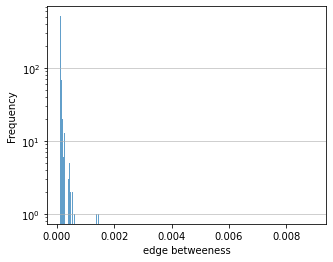

In [18]:
# generate dictionary with edges as keys and centrality as value
d_edge_btw = dict(nx.edge_betweenness_centrality(G_celltype, weight=sim_score))

# optional: consider distribution of betweenness values
plt.figure(figsize=(5,4))
plt.hist(d_edge_btw.values(), bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('edge betweeness')
plt.ylabel('Frequency')
plt.yscale('log')



To reach the extreme case, we will progressively filter edges based on this centrality measure until the network approaches the point of fragmentation. 

As a result, the maximum number of edges will be filtered out, adhering to the fragmentation criterion.

This filtering step may take a minute.

In [19]:
G_celltype_filteredbtw = remove_low_ranked_edges(G_celltype, d_edge_btw)

print('# nodes: ', G_celltype_filteredbtw.number_of_nodes())
print('# edges: ', G_celltype_filteredbtw.number_of_edges())
print('# of connected components: ', nx.number_connected_components(G_celltype_filteredbtw))
print('network density (# present links divided by all possible links): ', nx.density(G_celltype_filteredbtw))

# nodes:  143
# edges:  142
# of connected components:  1
network density (# present links divided by all possible links):  0.013986013986013986


### basic layout

For positioning the nodes in 3D space, we use the spring layout, which is considered the most popular method. 

However, for larger networks, this approach has certain drawbacks. It often results in a somewhat pointless layout known as "hairball," which is difficult for the human eye to comprehend and tends to obscure structural patterns.

We will discuss some other network layouts in the notebook: `protein_atlas_celltypenetwork.ipynb`

In [20]:

pos3D_spg = nx.spring_layout(G_celltype_filteredbtw, dim=3, iterations=200)

plotly_preview(G_celltype_filteredbtw, pos = pos3D_spg)

In [140]:

# Pickle the object
# with open('G_celltype_filtered.pkl', 'wb') as file:
#     pk.dump(G_celltype_filtered, file)

# # Load the pickled object
with open('G_celltype_filtered.pkl', 'rb') as file:
    G_celltype_filtered = pk.load(file)

print('# nodes: ', G_celltype_filtered.number_of_nodes())
print('# edges: ', G_celltype_filtered.number_of_edges())
print('# of connected components: ', nx.number_connected_components(G_celltype_filtered))
print('network density (# present links divided by all possible links): ', nx.density(G_celltype_filtered))


# nodes:  143
# edges:  142
# of connected components:  1
network density (# present links divided by all possible links):  0.013986013986013986


For larger networks centrality calculation can take lot of cpu time.

The disparity filter (or backboning method) is a fast and reliable alternative.

(`https://doi.org/10.1073/pnas.08089041`)



In [32]:
def backbone(G, alpha = 0.05):
    """
    Computes the backbone of a graph based on a disparity condition.
    The backbone of a graph is obtained by removing edges that do not satisfy
    the disparity condition based on the given alpha value.

    Parameters:
    - G (networkx.Graph): The input graph.
    - alpha (float): The threshold value for the disparity condition.

    Returns:
    - G_filtered (networkx.Graph): The backbone graph obtained by removing edges
      that violate the disparity condition.
    """

    # Calculate nodes' weights
    d_node_s = {node: sum(G[node][nn]['weight'] for nn in G.neighbors(node)) for node in G.nodes()}

    # Create a new graph for the result
    G_filtered = nx.Graph()

    # Iterate through edges and test the disparity condition
    for a, b in G.edges():
        w = G[a][b]['weight']
        pa = w / d_node_s[a]
        ka = G.degree(a)
        alpha1 = pa + (1.0 - pa) ** (ka - 1)
        pb = w / d_node_s[b]
        kb = G.degree(b)
        alpha2 = pb + (1.0 - pb) ** (kb - 1)

        if alpha1 < alpha or alpha2 < alpha:
            G_filtered.add_edge(a, b, weight=w)

    return G_filtered


This method usually eliminates a few nodes rapidly while keeping the largest connected component intact.

To find a suitable value for alpha, we assess the number of removed edges, aiming to maximize it, and compare it to the largest connected component, which should remain unaltered.

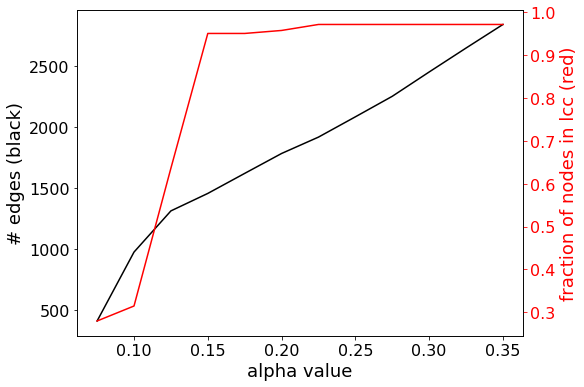

In [35]:
l_t = []
l_lcc = []
l_Nedges = []
for alpha in np.arange(.35,.05,-.025):
    l_t.append(alpha)
    G_bbone = backbone(G_celltype,alpha)
    G_lcc_set = max(nx.connected_components(G_bbone), key=len)
    l_lcc.append(1.*len(G_lcc_set)/G_celltype.number_of_nodes())
    l_Nedges.append(G_bbone.number_of_edges())

plt.figure(figsize=(8,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(l_t,l_Nedges , 'k-')
ax2.plot(l_t,l_lcc, 'r-')
ax1.set_xlabel('alpha value', fontsize=18)
ax2.set_ylabel('fraction of nodes in lcc (red)', fontsize=18)
ax1.set_ylabel('# edges (black)', fontsize=18)
tick_color_left = 'k'
tick_color_right = 'r'
ax1.tick_params(axis='both', which='major', colors=tick_color_left,labelsize=16)
ax2.tick_params(axis='both', which='major', colors=tick_color_right,labelsize=16)
ax1.xaxis.label.set_color(tick_color_left)
ax1.yaxis.label.set_color(tick_color_left)
ax2.yaxis.label.set_color(tick_color_right)

In [42]:
alpha = 0.15
G_bbone = backbone(G_celltype,alpha)

print('# nodes: ', G_bbone.number_of_nodes())
print('# edges: ', G_bbone.number_of_edges())
print('# of connected components: ', nx.number_connected_components(G_bbone))
print('network density (# present links divided by all possible links): ', nx.density(G_bbone))

# nodes:  136
# edges:  1456
# of connected components:  1
network density (# present links divided by all possible links):  0.15860566448801744


In [43]:
pos3D_spg = nx.spring_layout(G_bbone, dim=3, iterations=200)

plotly_preview(G_bbone, pos = pos3D_spg)